# MUTI CLASIFICATION LUNG

## LOAD DATASET

In [83]:
import pandas as pd
import random
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig, AutoModelForImageClassification
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import os
import shutil
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch import device
from torchvision import transforms

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [84]:
# Load train and validation data
df_train = pd.read_csv('./CheXpert-v1.0-small/train.csv')
df_val = pd.read_csv('./CheXpert-v1.0-small/valid.csv')

if not df_train.empty and not df_val.empty:
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


## EDA

In [85]:
# Display first 5 rows of validation data
df_train.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [86]:
df_val.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
229,CheXpert-v1.0-small/valid/patient64736/study1/...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230,CheXpert-v1.0-small/valid/patient64737/study1/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231,CheXpert-v1.0-small/valid/patient64738/study1/...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
232,CheXpert-v1.0-small/valid/patient64739/study1/...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,CheXpert-v1.0-small/valid/patient64740/study1/...,Male,90,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [87]:
df_train.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223414.000000,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
mean,60.430653,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,17.820925,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,0.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,49.000000,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,62.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,74.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Unik

In [88]:
unique_counts = df_train.loc[:, ~df_train.columns.isin(['Path'])].nunique()
print(pd.DataFrame({'train Unique Count': unique_counts}))

unique_counts = df_val.loc[:, ~df_val.columns.isin(['Path'])].nunique()
print(pd.DataFrame({'val Unique Count': unique_counts}))

                            train Unique Count
Sex                                          3
Age                                         74
Frontal/Lateral                              2
AP/PA                                        4
No Finding                                   1
Enlarged Cardiomediastinum                   3
Cardiomegaly                                 3
Lung Opacity                                 3
Lung Lesion                                  3
Edema                                        3
Consolidation                                3
Pneumonia                                    3
Atelectasis                                  3
Pneumothorax                                 3
Pleural Effusion                             3
Pleural Other                                3
Fracture                                     3
Support Devices                              3
                            val Unique Count
Sex                                        2
Age              

In [89]:
unique_values = df_train.loc[:, ~df_train.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
print(pd.DataFrame({'train Unique Values': unique_values.apply(lambda x: ', '.join(x))}))

                                                          train Unique Values
Sex                                                     Female, Male, Unknown
Age                         68, 87, 83, 41, 20, 33, 42, 69, 81, 76, 50, 22...
Frontal/Lateral                                              Frontal, Lateral
AP/PA                                                     AP, nan, PA, LL, RL
No Finding                                                           1.0, nan
Enlarged Cardiomediastinum                                nan, 0.0, 1.0, -1.0
Cardiomegaly                                              nan, -1.0, 0.0, 1.0
Lung Opacity                                              nan, 1.0, 0.0, -1.0
Lung Lesion                                               nan, 1.0, -1.0, 0.0
Edema                                                     nan, -1.0, 1.0, 0.0
Consolidation                                             nan, -1.0, 0.0, 1.0
Pneumonia                                                 nan, 0

In [90]:
unique_values = df_val.loc[:, ~df_val.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
print(pd.DataFrame({'val Unique Values': unique_values.apply(lambda x: ', '.join(x))}))

                                                            val Unique Values
Sex                                                              Male, Female
Age                         73, 70, 85, 42, 55, 56, 59, 53, 32, 34, 63, 84...
Frontal/Lateral                                              Frontal, Lateral
AP/PA                                                             AP, PA, nan
No Finding                                                           0.0, 1.0
Enlarged Cardiomediastinum                                           1.0, 0.0
Cardiomegaly                                                         1.0, 0.0
Lung Opacity                                                         1.0, 0.0
Lung Lesion                                                          0.0, 1.0
Edema                                                                0.0, 1.0
Consolidation                                                        0.0, 1.0
Pneumonia                                                       

### Distribusi Data

In [91]:
# Buat distribusi jumlah data 1.0, 0.0, dan -1.0 pada setiap label kondisi paru-paru
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

def distribusi_label(df, label_cols):
    distribusi = {}
    for label in label_cols:
        distribusi[label] = {
            '1.0': (df[label] == 1.0).sum(),
            '0.0': (df[label] == 0.0).sum(),
            '-1.0': (df[label] == -1.0).sum()
        }
    distribusi_df = pd.DataFrame(distribusi).T
    distribusi_df.columns = ['Jumlah 1.0', 'Jumlah 0.0', 'Jumlah -1.0']
    print(distribusi_df)

print("Distribusi label pada data train:")
distribusi_train = distribusi_label(df_train, label_cols)

print("\nDistribusi label pada data valid:")
distribusi_val = distribusi_label(df_val, label_cols)

Distribusi label pada data train:
                            Jumlah 1.0  Jumlah 0.0  Jumlah -1.0
No Finding                       22381           0            0
Enlarged Cardiomediastinum       10798       21638        12403
Cardiomegaly                     27000       11116         8087
Lung Opacity                    105581        6599         5598
Lung Lesion                       9186        1270         1488
Edema                            52246       20726        12984
Consolidation                    14783       28097        27742
Pneumonia                         6039        2799        18770
Atelectasis                      33376        1328        33739
Pneumothorax                     19448       56341         3145
Pleural Effusion                 86187       35396        11628
Pleural Other                     3523         316         2653
Fracture                          9040        2512          642
Support Devices                 116001        6137         1079

Distr

### Ratio imbalance

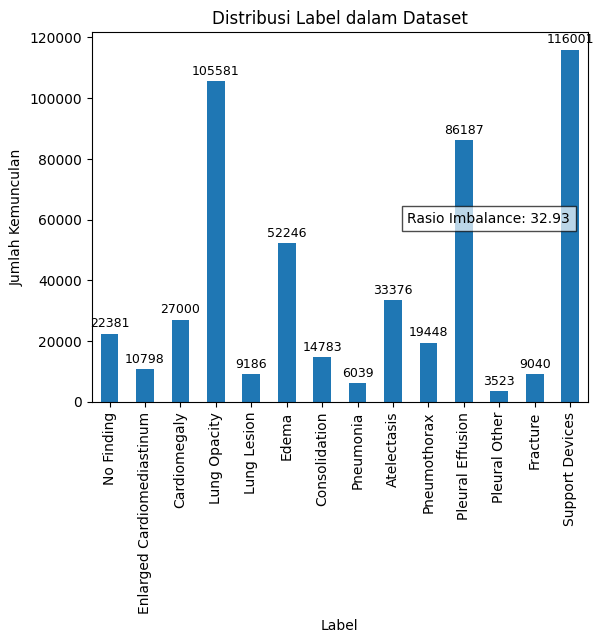

In [92]:
# Ambil 14 label terakhir dari kolom train_df dan valid_df, hitung distribusi label (jumlah 1.0)
label_counts = (df_train[label_cols] == 1.0).sum()

max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

# Buat grafik distribusi label
ax = label_counts.plot(kind='bar')
plt.title('Distribusi Label dalam Dataset')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')

# Tambahkan teks jumlah di atas setiap bar
for i, v in enumerate(label_counts):
    ax.text(i, v + max_count * 0.01, str(v), ha='center', va='bottom', fontsize=9, rotation=0)

# Tambahkan teks rasio imbalance di dalam grafik (pada sumbu y tertinggi)
plt.text(
    x=len(label_counts) - 1, 
    y=max_count - max_count * 0.5, 
    s=f'Rasio Imbalance: {imbalance_ratio:.2f}', 
    ha='right', va='bottom', fontsize=10, 
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.savefig('document/distribusi_label_rawdf.png')
plt.show()

### Korelasi

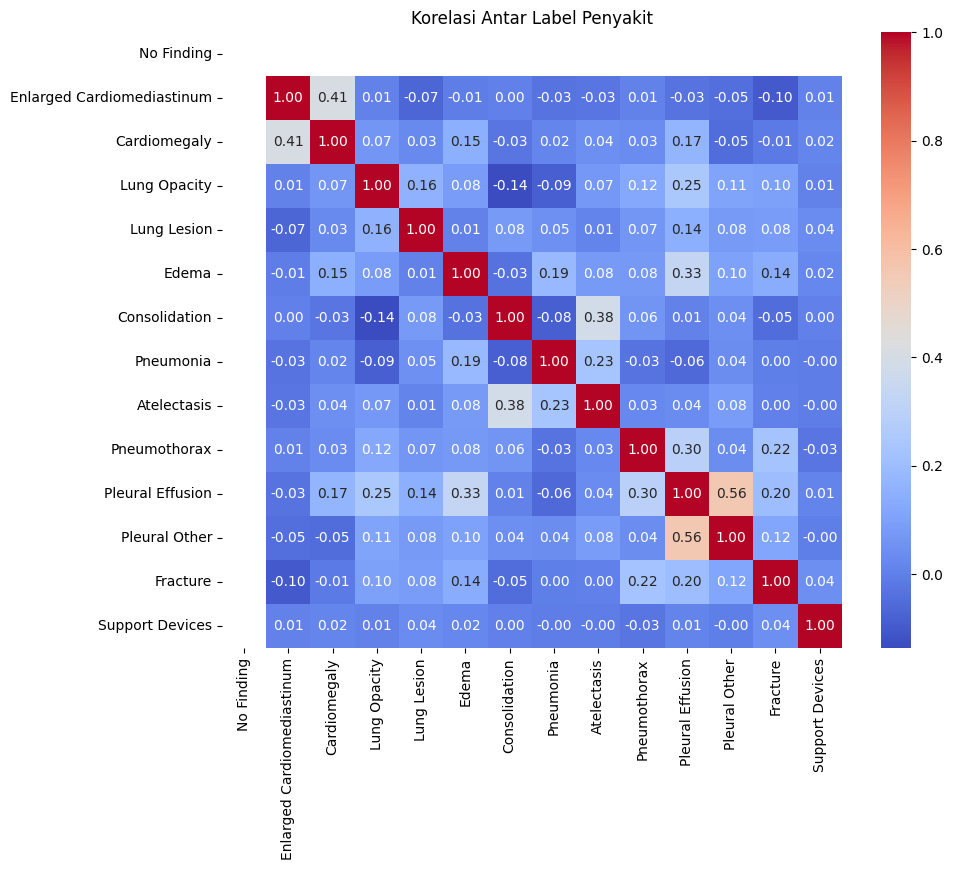

In [93]:
import seaborn as sns

# Menghitung korelasi antar label penyakit pada dataframe df
correlation_matrix = df_train[label_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Label Penyakit")
plt.savefig('document/korelasi_rawdf.png')
plt.show()

In [94]:
# import pandas as pd
# from collections import defaultdict
# from itertools import combinations

# label_cols = [
#     'Enlarged Cardiomediastinum', 
#     'Cardiomegaly',
#     'Lung Opacity', 
#     'Lung Lesion', 
#     'Edema', 
#     'Consolidation',
#     'Pneumonia',
#     'Atelectasis', 
#     'Pneumothorax', 
#     'Pleural Effusion',
#     # 'Pleural Other',
#     'Fracture',
#     # 'Support Devices'
# ]

# def analyze_bool_label_combinations(df, label_columns):
#     """
#     Menganalisis kombinasi label bool yang sering muncul bernilai 1.0
    
#     Parameters:
#     df (pd.DataFrame): DataFrame yang berisi data
#     label_columns (list): Daftar kolom label bool
    
#     Returns:
#     dict: Dictionary berisi kombinasi label dan jumlah kemunculannya
#     """
#     # Filter hanya kolom label
#     labels_df = df[label_columns]
    
#     # Pastikan semua nilai adalah float (1.0 atau 0.0)
#     labels_df = labels_df.astype(float)
    
#     # Hitung kombinasi label yang aktif (bernilai 1.0)
#     combination_counts = defaultdict(int)
    
#     for _, row in labels_df.iterrows():
#         # Dapatkan label yang aktif (bernilai 1.0)
#         active_labels = [label for label in label_columns if row[label] == 1.0]
        
#         # Hitung semua kombinasi dari label yang aktif
#         for r in range(1, len(active_labels)+1):
#             for combo in combinations(active_labels, r):
#                 combination_counts[combo] += 1
    
#     # Urutkan kombinasi berdasarkan frekuensi
#     sorted_combinations = sorted(combination_counts.items(), key=lambda x: x[1], reverse=True)
    
#     return sorted_combinations

# def display_combination_results(combinations, top_n=10):
#     """
#     Menampilkan hasil kombinasi label
    
#     Parameters:
#     combinations (list): List kombinasi label dan jumlahnya
#     top_n (int): Jumlah kombinasi teratas yang akan ditampilkan
#     """
#     print("Kombinasi Label yang Sering Muncul Bernilai 1.0:")
#     print("="*60)
#     print(f"{'Kombinasi Label':<40} | {'Jumlah Kemunculan':>15}")
#     print("-"*60)
    
#     for combo, count in combinations[:top_n]:
#         combo_str = ", ".join(combo)
#         print(f"{combo_str:<40} | {count:>15}")
    
#     print("\nTotal Kombinasi Unik:", len(combinations))

# # Analisis kombinasi label bool yang sering muncul bernilai 1.0
# label_columns = df_train.columns.tolist()
# combinations = analyze_bool_label_combinations(df_train, label_cols)
# display_combination_results(combinations, top_n=1446)  # Set


## PRE PROSESING

### Split Data

In [95]:
# split df_val menjadi valid 70%, dan test 30%
df_val, df_test = train_test_split(df_val, test_size=0.2, random_state=0, shuffle=False)
# %store df_test


print(f"train_df shape: {len(df_train)}") 
print(f"valid_df shape: {len(df_val)}") 
print(f"test_df shape: {len(df_test)}") 

train_df shape: 223414
valid_df shape: 187
test_df shape: 47


In [96]:
# acak isi dataframe df_train
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

### U-Once

In [97]:
# Ubah semua nilai -1.0 menjadi 1.0 U-Ones
df_train = df_train.replace(-1.0, 1.0)

### Selection Fiture

In [98]:
label_cols = [
    'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    'Lung Lesion', 
    'Edema', 
    'Consolidation',
    'Pneumonia',
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    # 'Pleural Other',
    'Fracture',
    # 'Support Devices'
]

# Hapus kolom yang tidak diperlukan
columns_to_drop = [
    'Sex', 
    'Age', 
    'Frontal/Lateral', 
    'AP/PA',
    'No Finding',
    # 'Enlarged Cardiomediastinum', 
    # 'Cardiomegaly',
    # 'Lung Opacity', 
    # 'Lung Lesion', 
    # 'Edema', 
    # 'Consolidation',
    # 'Pneumonia',
    # 'Atelectasis', 
    # 'Pneumothorax', 
    # 'Pleural Effusion',
    'Pleural Other',
    # 'Fracture',
    'Support Devices'
    ]

#### Drop Under 20

In [99]:
threshold_df = df_test

# cari label dengan data tertinggi
high_finding = threshold_df[label_cols].sum().max()
print(high_finding)

# catat label yang dibawah 20% dari label tertinggi
low_finding_labels = threshold_df[label_cols].sum() < (0.2 * high_finding)
low_finding_labels = low_finding_labels[low_finding_labels].index.tolist()
print(low_finding_labels)

# catat naris index yang memiliki label di bawah 20% dari label tertinggi
def delete_low_finding(df, low_finding_labels):
    low_finding_indices = df[df[low_finding_labels].any(axis=1)].index.tolist()
    print(low_finding_indices)
    print(len(low_finding_indices))

    # hapus data sesuai dengan index yang sudah dicatat
    df = df.drop(low_finding_indices)
    return df

df_train = delete_low_finding(df_train, low_finding_labels)
df_val = delete_low_finding(df_val, low_finding_labels)
df_test = delete_low_finding(df_test, low_finding_labels)

23.0
['Lung Lesion', 'Pneumonia', 'Pneumothorax', 'Fracture']
[2, 4, 10, 12, 13, 23, 27, 31, 35, 38, 42, 50, 60, 65, 66, 71, 74, 79, 93, 94, 97, 103, 113, 119, 121, 123, 125, 127, 128, 129, 131, 134, 137, 140, 147, 150, 151, 152, 153, 158, 160, 167, 183, 185, 191, 197, 200, 206, 208, 213, 214, 218, 221, 223, 224, 235, 236, 238, 239, 241, 242, 244, 246, 248, 251, 254, 263, 266, 267, 269, 270, 272, 276, 278, 282, 289, 293, 296, 298, 303, 305, 316, 319, 326, 328, 351, 357, 359, 361, 366, 368, 374, 375, 377, 384, 385, 386, 393, 395, 397, 400, 403, 404, 405, 410, 418, 419, 421, 427, 428, 432, 433, 434, 437, 448, 451, 457, 459, 460, 461, 462, 465, 473, 474, 476, 477, 480, 486, 487, 489, 492, 499, 507, 508, 510, 512, 515, 522, 524, 530, 535, 538, 539, 541, 542, 546, 551, 553, 556, 559, 560, 566, 577, 584, 597, 598, 600, 607, 609, 610, 612, 619, 621, 628, 629, 630, 637, 642, 649, 656, 658, 665, 666, 669, 670, 677, 678, 679, 680, 682, 683, 685, 690, 697, 698, 699, 703, 704, 727, 730, 734, 735, 

In [100]:
df_train.drop(low_finding_labels, axis=1, inplace=True)
df_val.drop(low_finding_labels, axis=1, inplace=True)
df_test.drop(low_finding_labels, axis=1, inplace=True)

####Drop data Lateral

In [101]:
# # jumlah data sebelum penghapusan
# jumlah_data_sebelum = df.shape[0]
# print(f"Jumlah data sebelum penghapusan: {jumlah_data_sebelum}")

# #drop baris dimana kolom 'Frontal/Lateral' bernilai 'Lateral'
# df = df.drop(df[df['Frontal/Lateral'] == 'Lateral'].index)

# #jumlah data setelah penghapusan
# jumlah_data_setelah = df.shape[0]
# print(f"Jumlah data setelah penghapusan: {jumlah_data_setelah}")

#### Drop Fiture

In [102]:
df_train = df_train.drop(columns=columns_to_drop)
df_val = df_val.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Pleural Other', 'Support Devices'] yang tidak diperlukan telah dihapus.


In [103]:
label_cols = [label for label in label_cols if label not in low_finding_labels]
label_cols

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Edema',
 'Consolidation',
 'Atelectasis',
 'Pleural Effusion']

### Hasil Pre-procesing

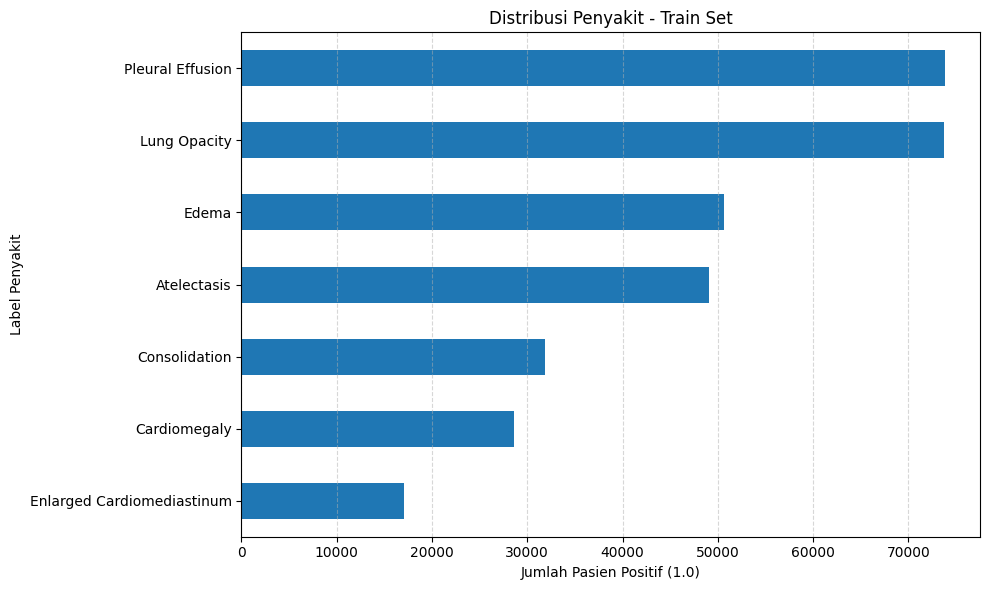

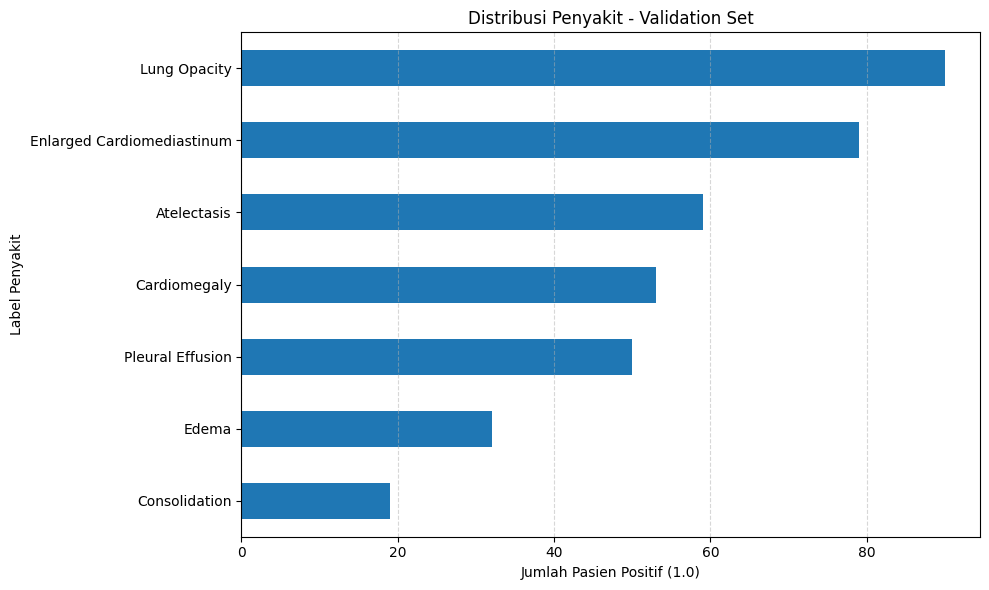

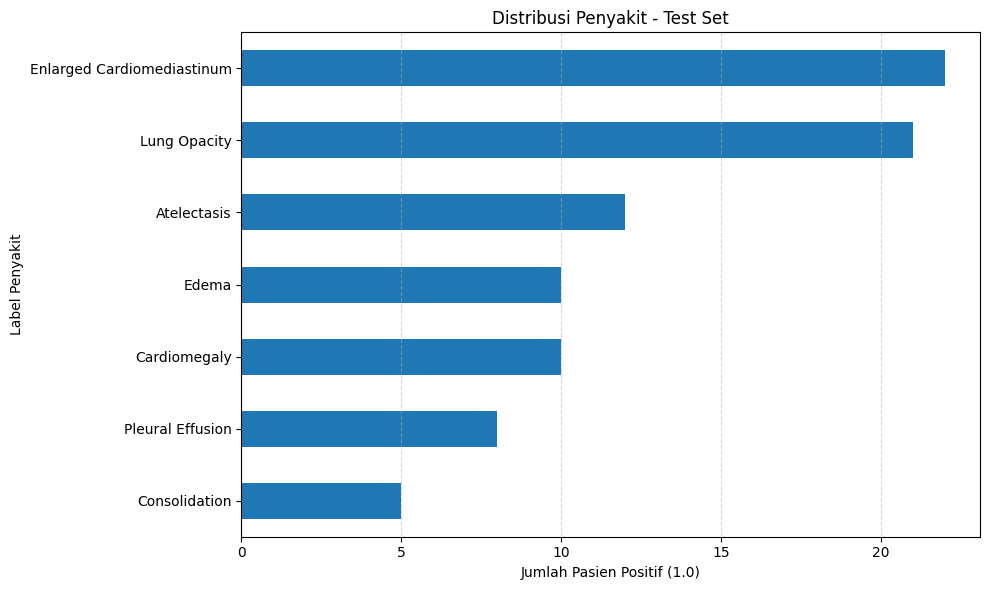

In [104]:
def plot_disease_distribution(df, disease_cols, title):
    # Hitung jumlah nilai 1.0 (positif) di setiap kolom penyakit
    disease_counts = df[disease_cols].sum().sort_values()

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    disease_counts.plot(kind='barh')
    plt.title(f'Distribusi Penyakit - {title}')
    plt.xlabel('Jumlah Pasien Positif (1.0)')
    plt.ylabel('Label Penyakit')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Gunakan DataFrame sebelum konversi ke format baru (pastikan variabel ini ada)
plot_disease_distribution(df_train, label_cols, 'Train Set')
plot_disease_distribution(df_val, label_cols, 'Validation Set')
plot_disease_distribution(df_test, label_cols, 'Test Set')


### Saving to .csv

In [105]:
df_test.to_csv('df_test.csv', index=False)
df_val.to_csv('df_val.csv', index=False)

### Konversi dataset

In [106]:
'''
membuat dataset baru denbgan memasukkan path dan label
hanya untuk label dengan nilai 1.0

return yang dihasilkan adalah created dataset baru:
new_df = [{'Path': 'path/to/image1.jpg', 'Labels': ['Label1', 'Label2']},
        {'Path': 'path/to/image2.jpg', 'Labels': ['Label3']},
        ...
    ]
'''
def create_label_dataset(df):
    label_columns_temp = df.columns[1:]  # kolom label (kecuali 'Path')
    df2 = []  # list untuk menyimpan data baru
    for idx, row in df.iterrows():
        labels = [col for col in label_columns_temp if row[col] == 1.0]
        df2.append({'Path': row['Path'], 'Labels': labels})

    # Konversi df2 ke DataFrame agar berbentuk tabel
    # df2 = pd.DataFrame(df2, columns=['Path', 'Labels'])
    return df2

df_train = create_label_dataset(df_train)
df_val = create_label_dataset(df_val)
df_test = create_label_dataset(df_test)

In [107]:
print("Jumlah data pada train_df:", {len(df_train)})
print("Jumlah data pada valid_df:", {len(df_val)})
print("Jumlah data pada test_df:", {len(df_test)})

Jumlah data pada train_df: {161859}
Jumlah data pada valid_df: {172}
Jumlah data pada test_df: {45}


## PROCESING

### Data Loader

In [108]:
'''
label2id dan id2label digunakan untuk membuat mapping label ke index dan sebaliknya
fungsi ini akan mengubah label menjadi index untuk memudahkan pemrosesan data
dan sebaliknya mengubah index menjadi label untuk interpretasi hasil.

contoh output:
label2id = {'Enlarged Cardiomediastinum': 0, 'Cardiomegaly': 1, 'Lung Opacity': 2,
            'Lung Lesion': 3, 'Edema': 4, 'Consolidation': 5, 'Pneumonia': 6,
            'Atelectasis': 7, 'Pneumothorax': 8, 'Pleural Effusion': 9,
            'Fracture': 10}
id2label = {0: 'Enlarged Cardiomediastinum', 1: 'Cardiomegaly', 2: 'Lung Opacity',
            3: 'Lung Lesion', 4: 'Edema', 5: 'Consolidation', 6: 'Pneumonia',
            7: 'Atelectasis', 8: 'Pneumothorax', 9: 'Pleural Effusion',
            10: 'Fracture'}
'''
label2id = {label: i for i, label in enumerate(label_cols)}
id2label = {i: label for label, i in label2id.items()}

'''
cheXpertDataset adalah custom dataset untuk CheXpert multilabel
Dataset ini akan mengembalikan dictionary dengan key 'Path' untuk gambar dan 'Labels' untuk label dalam bentuk vektor biner (encoding data).
Vektor biner ini akan memiliki panjang sesuai dengan jumlah label yang ada ndan berurutan sesuai label2id, 
dengan nilai 1.0 jika label tersebut ada pada gambar, dan 0.0 jika tidak ada.

contoh return yang dihasilkan:
{
    'Path': <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B2C1D3A90>,
    'Labels': tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
}
Dataset ini dapat digunakan dengan Trainer dari HuggingFace untuk pelatihan model.
'''
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}


### Image Processor

In [109]:
model_name = "google/vit-base-patch16-224-in21k"  # Ganti dengan model yang sesuai
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,  # This will ignore the classifier head size mismatch
)

def collate_fn(batch):
    pixel_values = torch.stack([item["Path"] for item in batch])
    labels = torch.stack([item["Labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Argumentation

In [110]:
'''
transformasi untuk preprocessing gambar dan augmentasi
Transformasi ini mencakup:
- CenterCropPercent: Crop tengah gambar dengan persentase tertentu
- Resize: Ubah ukuran gambar menjadi 224x224 piksel
- RandomHorizontalFlip: Augmentasi flip horizontal dengan probabilitas 0.5
- RandomRotation: Augmentasi rotasi acak dengan derajat maksimum 15
- ToTensor: Konversi gambar ke tensor PyTorch
- Normalize: Normalisasi gambar dengan mean dan std dari model ViT

Transformasi ini akan diterapkan pada dataset CheXpertDataset untuk pelatihan dan validasi.
'''

# Crop tengah dengan hitungan persen
class CenterCropPercent:
    def __init__(self, percent):
        self.percent = percent

    def __call__(self, img):
        w, h = img.size
        crop_w, crop_h = int(w * self.percent), int(h * self.percent)
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        right = left + crop_w
        bottom = top + crop_h
        return img.crop((left, top, right, bottom))

train_transform = transforms.Compose([
    CenterCropPercent(0.85),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Tambahkan augmentasi flip horizontal
    transforms.RandomRotation(degrees=15),  # Tambahkan augmentasi rotasi acak
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

val_transform = transforms.Compose([
    CenterCropPercent(0.85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

'''
lung_datasets adalah dictionary yang berisi dataset untuk pelatihan dan validasi.
Kedua dataset ini menggunakan CheXpertDataset yang telah didefinisikan sebelumnya.
Dataset ini akan mengembalikan gambar yang telah diproses dan label dalam bentuk vektor biner.

Transformasi yang digunakan adalah train_transform untuk pelatihan dan val_transform untuk validasi.
Dataset ini dapat digunakan dengan Trainer dari HuggingFace untuk pelatihan model.

Contoh output dari lung_datasets['train'][1]:
{'Path': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],  
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'Labels': tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])}

Setiap lung_datasets dipangil, dia akan selalu menampilkan gambar yang berbeda karena menggunakan random sampling.
'''

lung_datasets = {
    "train": CheXpertDataset(df_train, train_transform, label2id),
    "validation": CheXpertDataset(df_train, val_transform, label2id),
    "test": CheXpertDataset(df_test, test_transform, label2id)
}

In [111]:
print(lung_datasets['train'][3])  # Tampilkan contoh data dari dataset train

{'Path': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'Labels': tensor([0., 0., 0., 0., 0., 0., 1.])}


### Training Setup

In [112]:
'''
Fungsi compute_metrics digunakan untuk menghitung berbagai metrik evaluasi dari prediksi model.
Fungsi ini menerima prediksi model dalam bentuk tuple (logits, labels) dan mengembalikan dictionary dengan metrik-metrik yang dihitung.
Metrik yang dihitung meliputi:
- macro_f1: F1 score dengan rata-rata makro
- macro_accuracy: Akurasi dengan rata-rata makro
- macro_precision: Precision dengan rata-rata makro
- macro_recall: Recall dengan rata-rata makro
- auc: Area Under the Curve (AUC) dari ROC

Fungsi ini menggunakan fungsi-fungsi dari sklearn untuk menghitung metrik-metrik tersebut.
'''

def compute_metrics(pred):
    # logits, labels = pred
    # probs = torch.sigmoid(torch.tensor(logits)).numpy() # Convert logits to probabilities
    # preds = (probs > 0.5).astype(int)
    # labels = labels.astype(int)

    logits, labels = pred

    probs = torch.sigmoid(torch.tensor(logits)).numpy() # Convert logits to probabilities
    preds = [[x >= 0.5 for x in inner_list] for inner_list in probs]
    preds = [[int(x) for x in inner_list] for inner_list in preds]

    labels = labels.astype(int)
    labels = [[int(x) for x in inner_list] for inner_list in labels]

    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)
    auc = roc_auc_score(labels, probs)

    return {
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc": auc
    }

In [113]:
import torch.nn.functional as F
from transformers import Trainer

'''
CustomTrainer adalah subclass dari Trainer yang digunakan untuk mengimplementasikan label smoothing pada fungsi loss.
Fungsi compute_loss di override untuk menghitung loss dengan label smoothing.

Label smoothing digunakan untuk mengurangi overfitting dan meningkatkan generalisasi model pada data yang tidak seimbang.
Pada fungsi ini, label yang diberikan akan dihaluskan (smoothed) dengan epsilon tertentu, 
dan loss dihitung menggunakan binary cross entropy dengan logits dari model.
Fungsi ini mengembalikan loss, dan jika return_outputs=True, juga mengembalikan outputs dari model.

Contoh penggunaan:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)
trainer.train()
'''

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(inputs.get("pixel_values"))
        logits = outputs.logits

        # Label Smoothing (multi-label)
        smooth_eps = 0.1
        num_classes = labels.shape[1]
        labels_smooth = labels * (1 - smooth_eps) + (smooth_eps / num_classes)

        loss = F.binary_cross_entropy_with_logits(logits, labels_smooth)

        return (loss, outputs) if return_outputs else loss

In [114]:
!nvidia-smi

Wed Aug 13 06:07:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:05:00.0 Off |                  N/A |
|  0%   40C    P8              9W /  165W |   11797MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Fine-Tune

In [ ]:
# Nama metrik yang digunakan untuk memilih model terbaik
metric_name = "accuracy"

# Inisialisasi TrainingArguments untuk konfigurasi pelatihan
args = TrainingArguments(
    output_dir="chexpert-vit-model_v1",
    # eval_strategy="steps",
    # save_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,                    # Diperbesar dari 1e-5 untuk mempercepat konvergensi
    lr_scheduler_type="cosine",            # Alternatif: "linear", "cosine_with_restarts"
    warmup_ratio=0.1,                      # Warmup penting untuk stabilkan training
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=50,                   # Dikurangi (early stopping akan handle sisanya)
    # weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',                        # Direktori untuk menyimpan log
    remove_unused_columns=False,
)

# Inisialisasi Trainer dari HuggingFace
trainer = CustomTrainer(
    model=model,                            # Model yang akan dilatih
    args=args,                              # Argument konfigurasi training
    train_dataset=lung_datasets['train'],   # Dataset training
    eval_dataset=lung_datasets['validation'],# Dataset validasi
    data_collator=collate_fn,               # Fungsi untuk menggabungkan batch data
    compute_metrics=compute_metrics,        # Fungsi untuk menghitung metrik evaluasi
    tokenizer=processor,                     # Image processor/tokenizer
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=3,
        )
    ]
)

# Mulai proses training
trainer.train()

/tmp/ipykernel_906176/353705360.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# trainer.save_model("chexpert-vit-model")
# processor.save_pretrained("chexpert-vit-model")

['chexpert-vit-model/preprocessor_config.json']

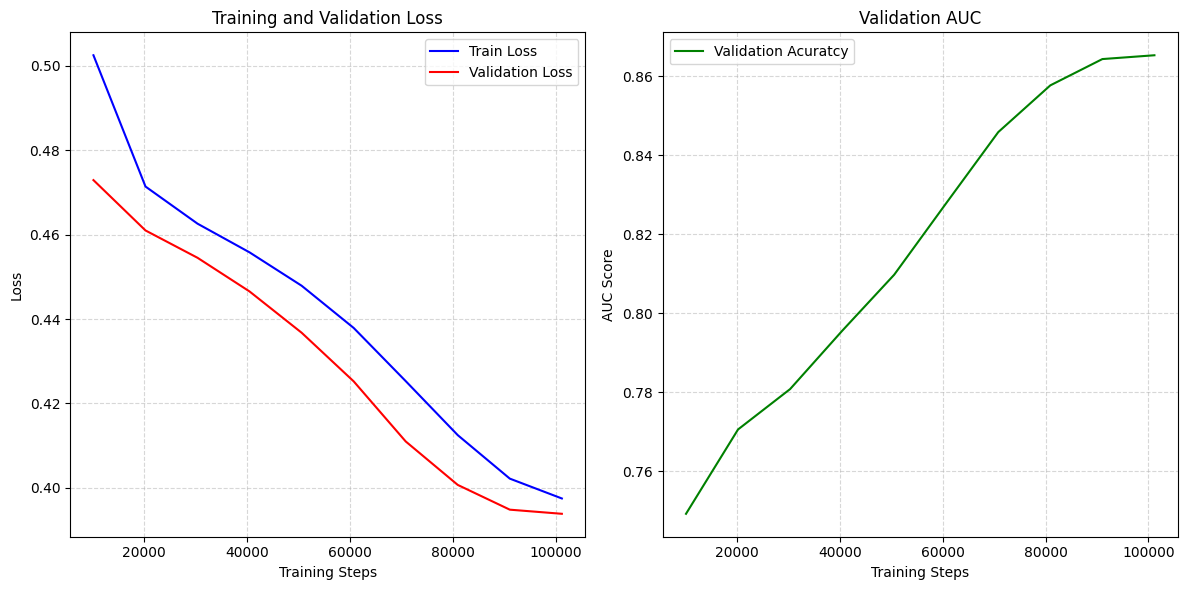

In [36]:
import matplotlib.pyplot as plt

def plot_training_metrics(trainer, save_path='document/training_evaluation_plot.png'):
    # Ambil log history
    training_logs = trainer.state.log_history
    
    # Inisialisasi penyimpanan data
    train_metrics = {'steps': [], 'loss': []}
    eval_metrics = {'steps': [], 'loss': [], 'auc': []}
    
    # Ekstrak metrik dari log
    for log in training_logs:
        if 'loss' in log and 'step' in log:  # Data training
            train_metrics['steps'].append(log['step'])
            train_metrics['loss'].append(log['loss'])
        elif 'eval_loss' in log:  # Data evaluasi
            eval_metrics['steps'].append(log['step'])
            eval_metrics['loss'].append(log['eval_loss'])
            if 'eval_auc' in log:  # Pastikan nama metrik AUC sesuai
                eval_metrics['auc'].append(log['eval_auc'])
    
    # Buat ics['steps'], train_metrics['loss'], 'b-', label='Train Loss')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['steps'], train_metrics['loss'], 'b-', label='Train Loss')
    plt.plot(eval_metrics['steps'], eval_metrics['loss'], 'r-', label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Plot 2: akurasi
    plt.subplot(1, 2, 2)
    if eval_metrics['auc']:  # Hanya plot jika AUC tersedia
        plt.plot(eval_metrics['steps'], eval_metrics['auc'], 'g-', label='Validation Acuratcy')
        plt.xlabel('Training Steps')
        plt.ylabel('AUC Score')
        plt.title('Validation AUC')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
    else:
        print("Warning: AUC data not found in logs!")
    
    # Simpan dan tampilkan
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Cara pakai:
plot_training_metrics(trainer)

## Test

probabilities    :  tensor(1.)
y_pred           :  tensor(3.7485)


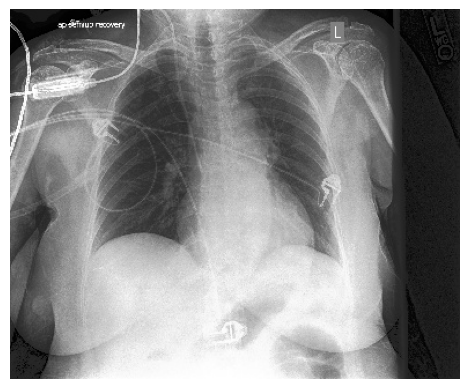

Actual : No Finding

TOP 5 PREDICTIONS:
1. Enlarged Cardiomediastinum: 0.39
2. Lung Opacity: 0.19
3. Pleural Effusion: 0.14
4. Atelectasis: 0.13
5. Edema: 0.06
6. Cardiomegaly: 0.06
7. Consolidation: 0.03


In [115]:
random_image = random.randint(0, len(df_test)-1)
image_test = Image.open(df_test[random_image]['Path']).convert("RGB")
labels_actual = df_test[random_image]['Labels']

image_processor = AutoImageProcessor.from_pretrained("model_vit_chexpert_saves")
model = ViTForImageClassification.from_pretrained("model_vit_chexpert_saves")

inputs = image_processor(image_test, return_tensors="pt")

# print("inputs", inputs)

with torch.no_grad():
    logits = model(**inputs).logits

# print("logits", logits)

probabilities = torch.nn.functional.softmax(logits, dim=-1)[0] # menampilkan persenan propability
y_pred = torch.sigmoid(probabilities)
print("probabilities    : ", probabilities.sum())
print("y_pred           : ", y_pred.sum())


# Dapatkan semua label dan probabilitasnya
all_labels = []
all_probs = []
for label_id, prob in enumerate(probabilities):
    label_name = model.config.id2label[label_id]
    all_labels.append(label_name)
    all_probs.append(prob.item())

# Urutkan berdasarkan probabilitas tertinggi
sorted_indices = np.argsort(all_probs)[::-1]  # ngurutin dengan cara melabelin index berurutan tinggi ke rendash
sorted_labels = [all_labels[i] for i in sorted_indices] # Shorting nama label
sorted_probs = [all_probs[i] for i in sorted_indices] # Shoreing id label

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
predicted_label_name = model.config.id2label[predicted_label]
predicted_prob = probabilities[predicted_label].item()

# Tampilkan gambar
plt.imshow(image_test)
plt.axis('off')
plt.show()

# if predicted_label_name==None:
#     print("Predict : No Finding")
# else:
#     print("Predict : ", predicted_label_name, predicted_label)

if labels_actual==[]:
    print("Actual : No Finding")
else:
    print("Actual : ", labels_actual)

# Tampilkan top 5 predictions
print("\nTOP 5 PREDICTIONS:")
for i in range(len(sorted_probs)):
    print(f"{i+1}. {sorted_labels[i]}: {sorted_probs[i]:.2f}")

# image_test

In [116]:
print(all_labels)
print("probabilities : ", probabilities)

y_pred = torch.sigmoid(probabilities)
y_actual = lung_datasets['test'][random_image]['Labels']

print("y_pred : ", y_pred)
print("y_actual : ", y_actual)

# Atau gunakan unsqueeze (tambah dimensi di axis 0)
y_pred = y_pred.unsqueeze(0)
y_actual = y_actual.unsqueeze(0)

print("y_pred : ", y_pred)
print("y_actual : ", y_actual)

auc_acuration = roc_auc_score(y_actual, y_pred, average=None)

print(auc_acuration)

['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']
probabilities :  tensor([0.3933, 0.0574, 0.1897, 0.0631, 0.0306, 0.1306, 0.1353])
y_pred :  tensor([0.5971, 0.5144, 0.5473, 0.5158, 0.5076, 0.5326, 0.5338])
y_actual :  tensor([0., 0., 0., 0., 0., 0., 0.])
y_pred :  tensor([[0.5971, 0.5144, 0.5473, 0.5158, 0.5076, 0.5326, 0.5338]])
y_actual :  tensor([[0., 0., 0., 0., 0., 0., 0.]])
[nan nan nan nan nan nan nan]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## Test All

In [117]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # Untuk progress bar

# Load model dan processor
my_image_processor = AutoImageProcessor.from_pretrained("chexpert-vit-model")
my_model = ViTForImageClassification.from_pretrained("chexpert-vit-model")
# model.eval()

dataset_test = CheXpertDataset(df_test, val_transform, label2id)

# Inisialisasi tempat penyimpanan hasil
all_probabilities = []
all_true_labels = []

# Loop melalui semua data test
for idx in tqdm(range(len(df_test)), desc="Processing Test Data"):
    image_test = Image.open(df_test[idx]['Path']).convert("RGB")
    y_actual = dataset_test[idx]['Labels']

    inputs = image_processor(image_test, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    probabilities = torch.sigmoid(probabilities)

    # Simpan hasil
    all_probabilities.append(probabilities)
    all_true_labels.append(y_actual)


Processing Test Data:   0%|          | 0/45 [00:00<?, ?it/s]

Processing Test Data: 100%|██████████| 45/45 [00:04<00:00,  9.18it/s]


In [118]:
import torch
from torch.nn.functional import sigmoid

# Setelah loop selesai, gabungkan semua tensor 1D menjadi tensor 2D
all_true_labels = torch.stack(all_true_labels)  # Shape: (n_samples, n_labels)
all_probabilities = torch.stack(all_probabilities)  # Shape: (n_samples, n_labels)


In [119]:
auc_acuration = roc_auc_score(all_true_labels, all_probabilities, average=None)
auc_acuration

array([0.35770751, 0.69428571, 0.52380952, 0.86571429, 0.535     ,
       0.65909091, 0.89527027])

In [122]:
model.config.id2label

{0: 'Enlarged Cardiomediastinum',
 1: 'Cardiomegaly',
 2: 'Lung Opacity',
 3: 'Edema',
 4: 'Consolidation',
 5: 'Atelectasis',
 6: 'Pleural Effusion'}


ANALISIS UNTUK LABEL: ENLARGED CARDIOMEDIASTINUM


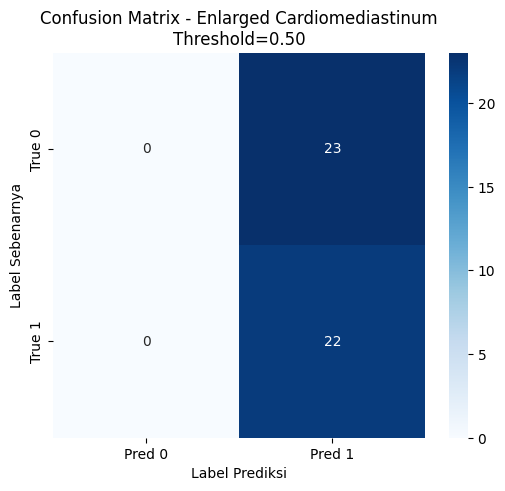

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        23
     Positif       0.49      1.00      0.66        22

    accuracy                           0.49        45
   macro avg       0.24      0.50      0.33        45
weighted avg       0.24      0.49      0.32        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.4889
- F1-Score: 0.6567

ANALISIS UNTUK LABEL: CARDIOMEGALY


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


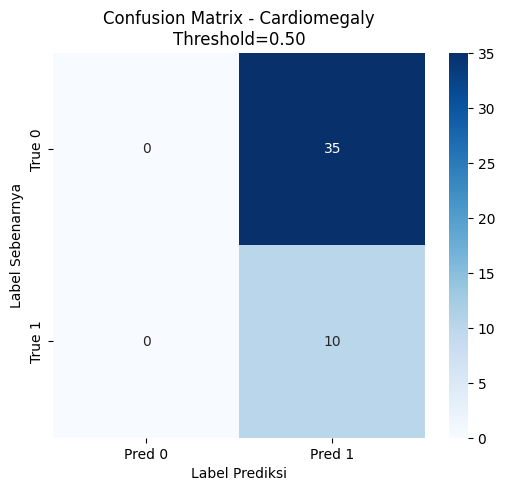

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        35
     Positif       0.22      1.00      0.36        10

    accuracy                           0.22        45
   macro avg       0.11      0.50      0.18        45
weighted avg       0.05      0.22      0.08        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.2222
- F1-Score: 0.3636

ANALISIS UNTUK LABEL: LUNG OPACITY


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


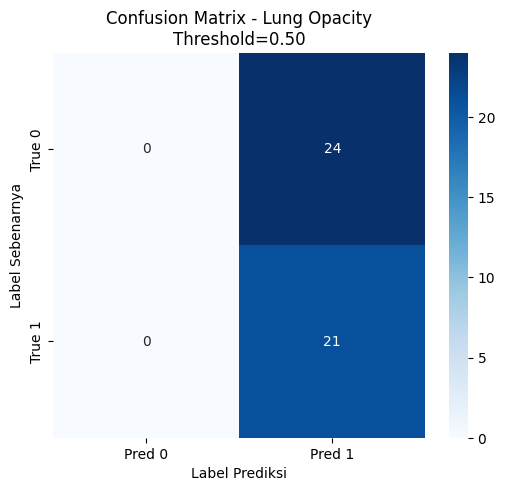

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        24
     Positif       0.47      1.00      0.64        21

    accuracy                           0.47        45
   macro avg       0.23      0.50      0.32        45
weighted avg       0.22      0.47      0.30        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.4667
- F1-Score: 0.6364

ANALISIS UNTUK LABEL: EDEMA


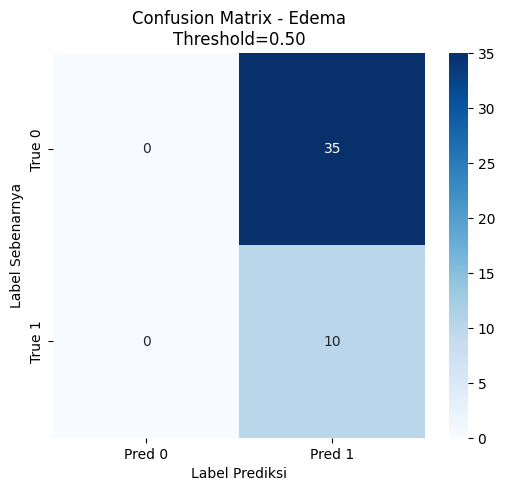

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        35
     Positif       0.22      1.00      0.36        10

    accuracy                           0.22        45
   macro avg       0.11      0.50      0.18        45
weighted avg       0.05      0.22      0.08        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.2222
- F1-Score: 0.3636

ANALISIS UNTUK LABEL: CONSOLIDATION


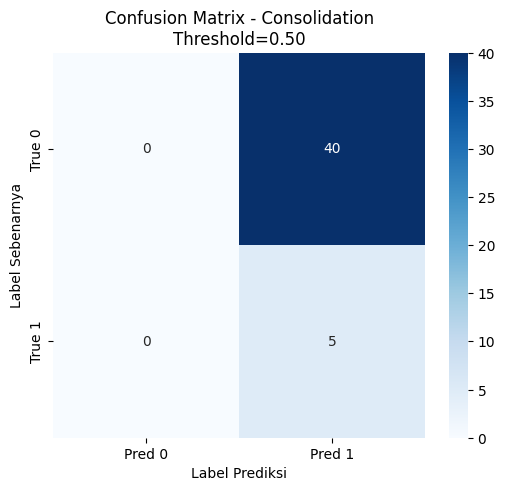

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        40
     Positif       0.11      1.00      0.20         5

    accuracy                           0.11        45
   macro avg       0.06      0.50      0.10        45
weighted avg       0.01      0.11      0.02        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.1111
- F1-Score: 0.2000

ANALISIS UNTUK LABEL: ATELECTASIS


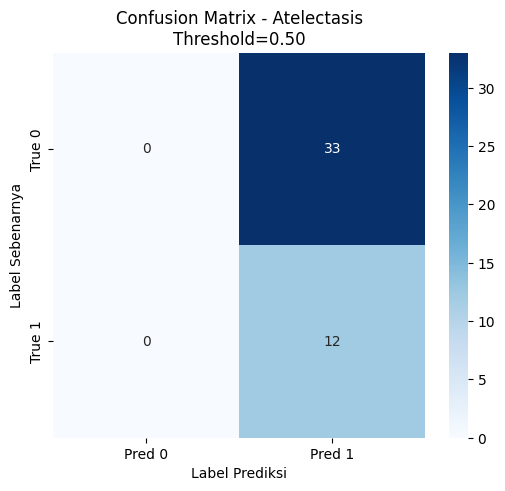

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        33
     Positif       0.27      1.00      0.42        12

    accuracy                           0.27        45
   macro avg       0.13      0.50      0.21        45
weighted avg       0.07      0.27      0.11        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.2667
- F1-Score: 0.4211

ANALISIS UNTUK LABEL: PLEURAL EFFUSION


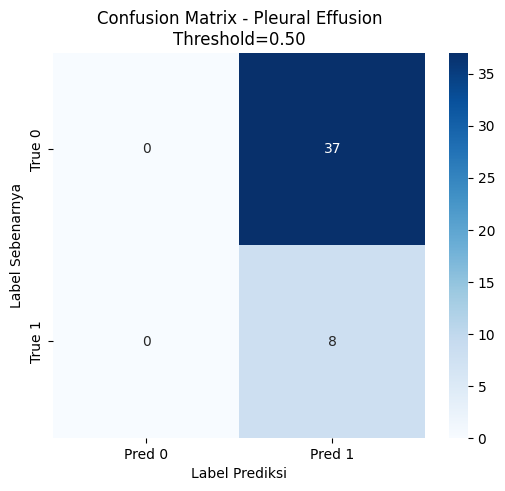

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        37
     Positif       0.18      1.00      0.30         8

    accuracy                           0.18        45
   macro avg       0.09      0.50      0.15        45
weighted avg       0.03      0.18      0.05        45

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.1778
- F1-Score: 0.3019


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [123]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix_per_label(all_true_labels, all_probabilities, id2label, threshold=0.5):
    """
    Membuat confusion matrix dan laporan klasifikasi untuk setiap label.
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) - label sebenarnya
        all_probabilities: Tensor 2D (n_samples, n_labels) - probabilitas prediksi
        id2label: Dictionary mapping id ke nama label
        threshold: Nilai ambang untuk konversi probabilitas ke prediksi biner
    """
    # Konversi ke numpy array di CPU
    y_true = all_true_labels.cpu().numpy()
    y_pred = (all_probabilities.cpu().numpy() >= threshold).astype(int)
    
    n_labels = y_true.shape[1]
    
    for i in range(n_labels):
        label_name = id2label[i]
        print(f"\n{'='*50}")
        print(f"ANALISIS UNTUK LABEL: {label_name.upper()}")
        print(f"{'='*50}")
        
        # Hitung confusion matrix
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        # Visualisasi
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Pred 0', 'Pred 1'], 
                    yticklabels=['True 0', 'True 1'])
        plt.title(f'Confusion Matrix - {label_name}\nThreshold={threshold:.2f}')
        plt.ylabel('Label Sebenarnya')
        plt.xlabel('Label Prediksi')
        plt.show()
        
        # Laporan klasifikasi
        print(classification_report(y_true[:, i], y_pred[:, i], 
                                    target_names=['Negatif', 'Positif']))
        
        # Hitung metrik tambahan
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Detail Metrik:")
        print(f"- Sensitivity/Recall: {sensitivity:.4f}")
        print(f"- Specificity: {specificity:.4f}")
        print(f"- Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "- Precision: 0")
        print(f"- F1-Score: {2*tp / (2*tp + fp + fn):.4f}" if (2*tp + fp + fn) > 0 else "- F1-Score: 0")

# Contoh penggunaan
plot_confusion_matrix_per_label(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label,
    threshold=0.5 
)